# 尝试更深层的eDMDAE


## 1. 读取筛选后的数据


In [1]:
import pandas as pd
import torch

# 选取需要的列
COLUMN_INDEX = [
    "Index",
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Stn Press (kPa)",
]
data = pd.read_csv("Data/DataSet.csv")[COLUMN_INDEX].to_numpy()

data_tensor = torch.tensor(data, dtype=torch.float32)
data_tensor

tensor([[ 0.0000e+00,  1.5000e+00, -3.6000e+00,  6.9000e+01,  3.9000e+01,
          9.9810e+01],
        [ 1.0000e+00,  1.5000e+00, -3.9000e+00,  6.7000e+01,  3.5000e+01,
          1.0001e+02],
        [ 2.0000e+00,  1.0000e+00, -4.3000e+00,  6.8000e+01,  3.2000e+01,
          1.0014e+02],
        ...,
        [ 1.7517e+04,  4.0000e+00,  3.6000e+00,  9.7000e+01,  3.2000e+01,
          9.9150e+01],
        [ 1.7518e+04,  4.0000e+00,  3.6000e+00,  9.7000e+01,  3.0000e+01,
          9.8800e+01],
        [ 1.7519e+04,  4.0000e+00,  3.7000e+00,  9.8000e+01,  1.5000e+01,
          9.8570e+01]])

## 2. 模型定义与训练

划分训练集和测试集


In [2]:
from Network import *

# 设置随机种子以确保结果可重复
torch.manual_seed(42)

train_loader, test_loader, train_index, test_index = TimeSeriesDataSplit2Loaders(
    data_tensor, BATCH_SIZE=16, RATIO=0.5, SHUFFLE=True
)

定义Auto Encoder结构


In [3]:
from torchinfo import summary

input_size = 5
hidden_size_1 = 8
hidden_size_2 = 16
hidden_size_3 = 64
dropout_prob = 0.2

ENCODER = nn.Sequential(
    nn.Linear(input_size, hidden_size_1),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size_1),
    nn.Dropout(dropout_prob),
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size_2),
    nn.Linear(hidden_size_2, hidden_size_3),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size_3),
    nn.Dropout(dropout_prob),
)
DECODER = nn.Sequential(
    nn.Linear(hidden_size_3, hidden_size_2),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size_2),
    nn.Dropout(dropout_prob),
    nn.Linear(hidden_size_2, hidden_size_1),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size_1),
    nn.Dropout(dropout_prob),
    nn.Linear(hidden_size_1, input_size),
)

MyAE = AutoEncoder(ENCODER, DECODER)
INIT_WEIGHTS_XAVIER(MyAE)
summary(MyAE, (1, 5))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 5]                    --
├─Sequential: 1-1                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 8]                    48
│    └─ReLU: 2-2                         [1, 8]                    --
│    └─BatchNorm1d: 2-3                  [1, 8]                    16
│    └─Dropout: 2-4                      [1, 8]                    --
│    └─Linear: 2-5                       [1, 16]                   144
│    └─ReLU: 2-6                         [1, 16]                   --
│    └─BatchNorm1d: 2-7                  [1, 16]                   32
│    └─Linear: 2-8                       [1, 64]                   1,088
│    └─ReLU: 2-9                         [1, 64]                   --
│    └─BatchNorm1d: 2-10                 [1, 64]                   128
│    └─Dropout: 2-11                     [1, 64]                   --
├─Sequenti

训练模型


In [4]:
optimizer = torch.optim.Adam(MyAE.parameters(), lr=0.005, weight_decay=1e-5)
LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST = TRAIN_WITH_PROGRESS_BAR_eDMD(
    MyAE,
    NUM_EPOCHS=150,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=train_loader,
    TEST_LOADER=test_loader,
    TORCH_LOSS_TYPE=nn.MSELoss(),
    LOSS_WEIGHT=[0.5, 0.5],
    DEVICE=0,
)

PyTorch Version: 2.1.0.dev20230621+cu117
Training on cuda:0
====================================Start training====================================


Epoch 150/150: 100%|██████████| 548/548 [00:02<00:00, 219.18batch/s, loss=35.1]


====================================Finish training====================================



可视化


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:150: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

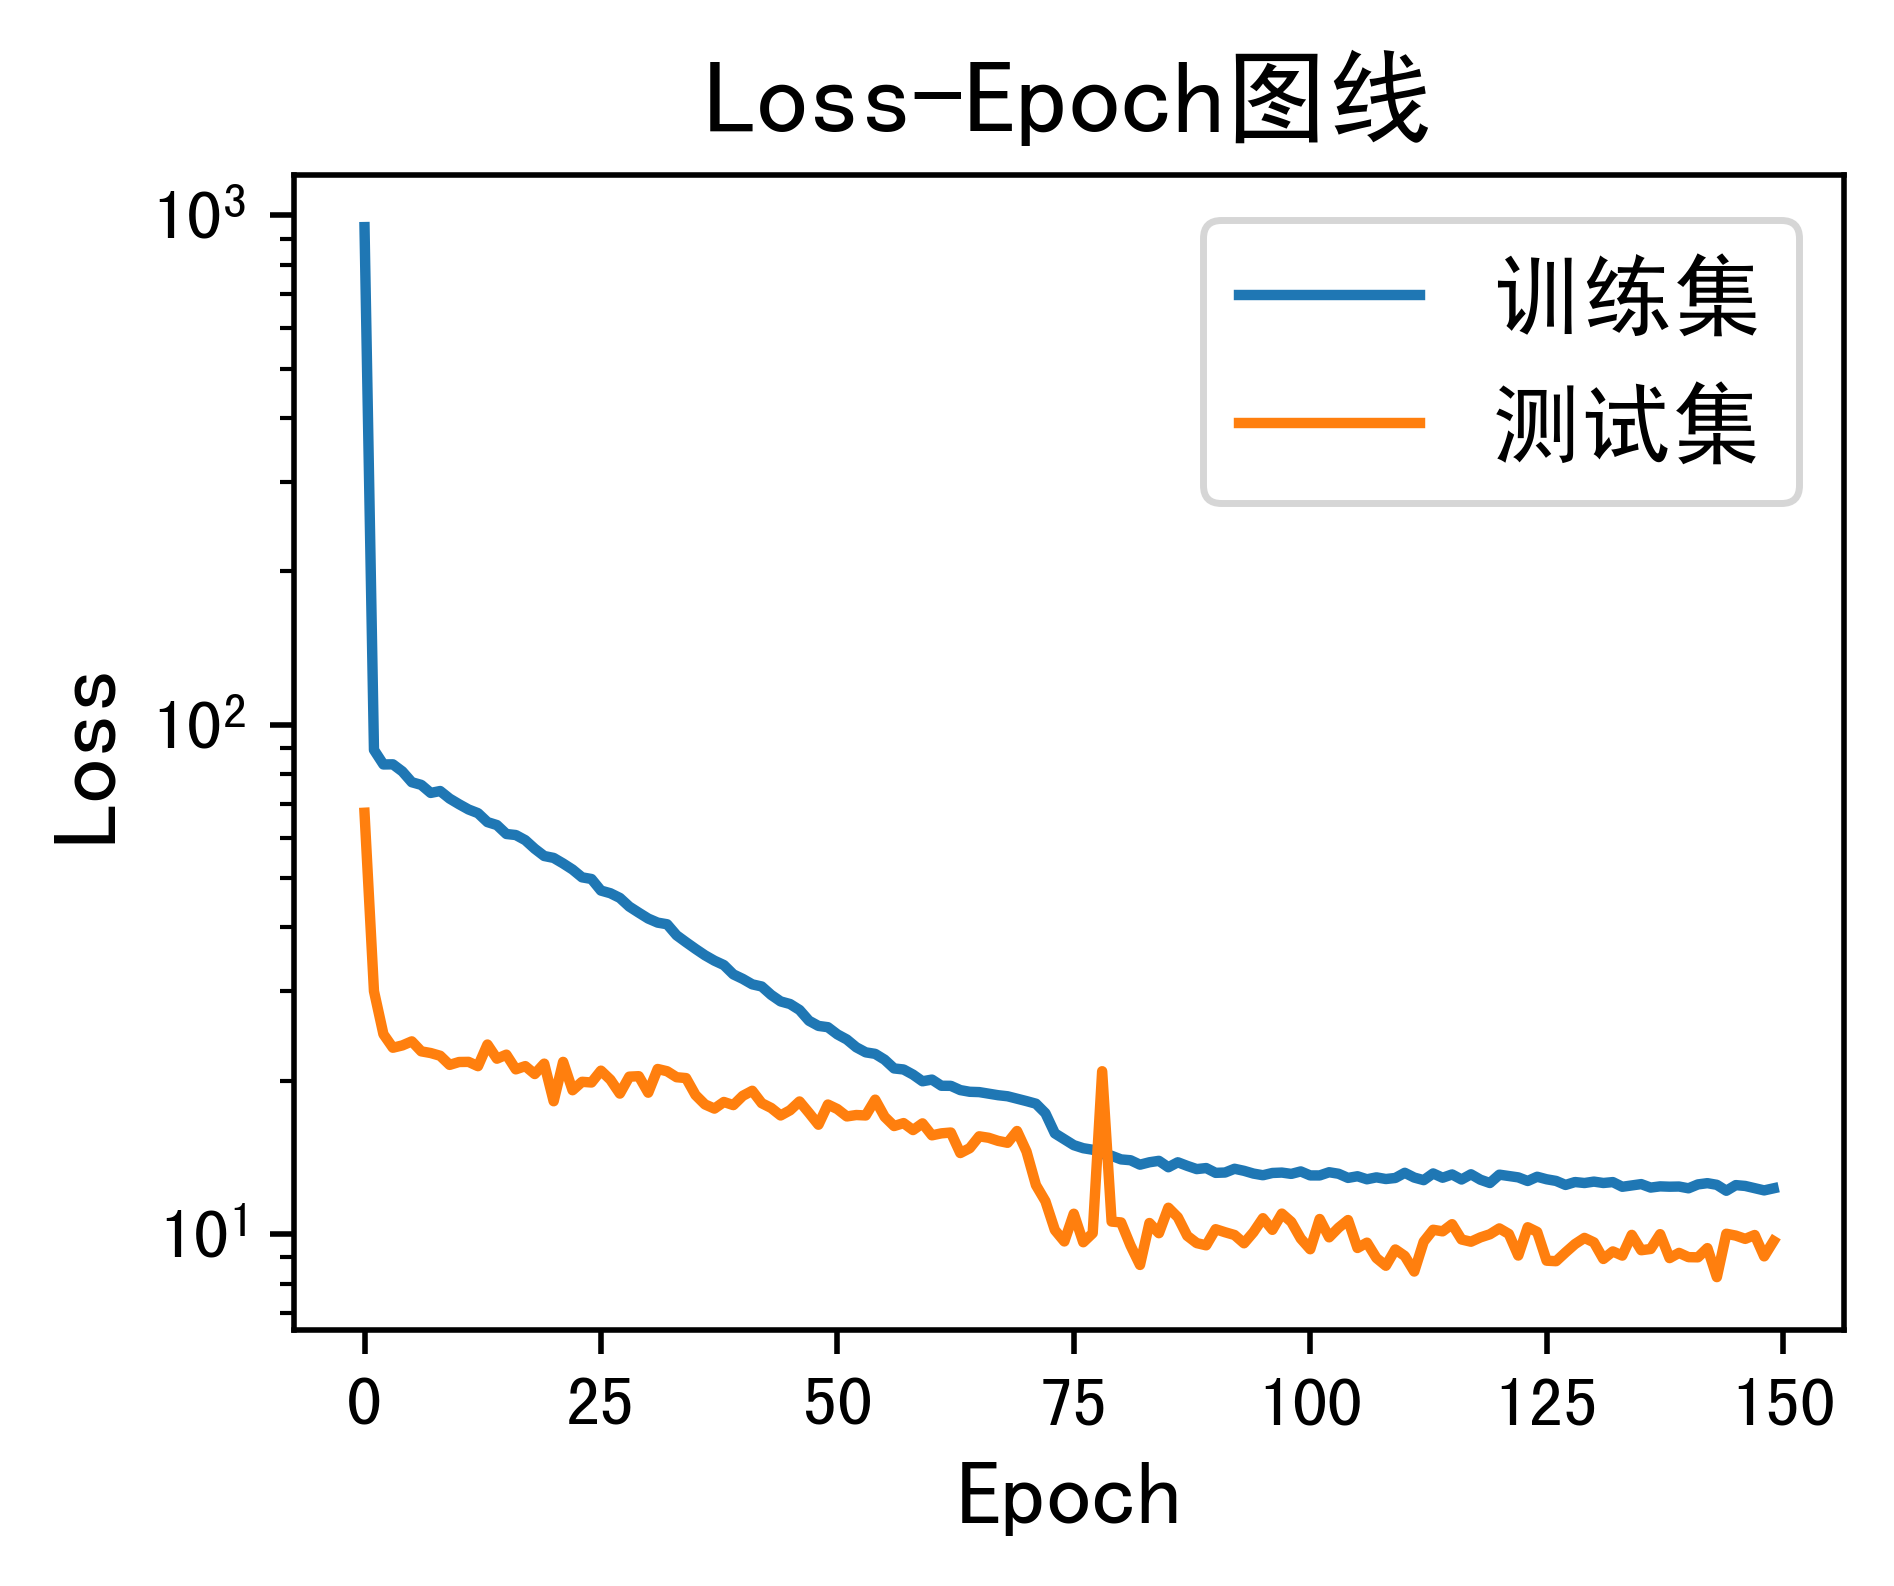

In [5]:
from Visualization import *

LossEpochPlot(
    LOSS_HISTORY=(LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST),
    LEGEND=["训练集", "测试集"],
    TITLE="Loss-Epoch图线",
    FILE_NAME="Images/07AE_Loss_Epoch.jpg",
    SAVE_FIG=True,
)

保存网络


In [6]:
torch.save(MyAE.encoder.state_dict(), "Networks/3Layer_eDMDEncoder.pth")
torch.save(MyAE.decoder.state_dict(), "Networks/3Layer_eDMDDecoder.pth")

## 3. 生成特征数据


In [7]:
ENCODER.load_state_dict(torch.load("Networks/3Layer_eDMDEncoder.pth"))
DECODER.load_state_dict(torch.load("Networks/3Layer_eDMDDecoder.pth"))

ENCODER.to("cpu")
DECODER.to("cpu")

Header = [f"Feature {i+1}" for i in range(hidden_size_3)]
# 选取需要的列
COLUMN_INDEX = [
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Stn Press (kPa)",
]
data = pd.read_csv("Data/DataSet.csv")[COLUMN_INDEX].to_numpy()
data_tensor = torch.tensor(data, dtype=torch.float32)

ENCODER.eval()
with torch.no_grad():
    feature_tensor = ENCODER(data_tensor)
    df = pd.DataFrame(data=feature_tensor.numpy(), columns=Header)

df.to_csv("Data/3Layer_Feature.csv", index=True)

## 4. 线性回归得到传递矩阵


划分训练集和测试集


In [8]:
feature_tensor = torch.tensor(
    pd.read_csv("Data/3Layer_Feature.csv")[Header].to_numpy(), dtype=torch.float32
)

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
train_loader, test_loader = Split2Loaders(
    feature_tensor[:-1, :], feature_tensor[1:, :], BATCHSIZE=8, RATIO=0.7, SHUFFLE=True
)

定义线性回归模型


In [9]:
MyLinearRegression = LinearRegression(
    INPUT_SIZE=hidden_size_3, OUTPUT_SIZE=hidden_size_3, BIAS=False
)
INIT_WEIGHTS_ZERO(MyLinearRegression)
summary(MyLinearRegression, (1, hidden_size_3))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 64]                   --
├─Linear: 1-1                            [1, 64]                   4,096
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

开始回归


In [10]:
optimizer = torch.optim.Adam(
    MyLinearRegression.parameters(), lr=0.005, weight_decay=1e-5
)
LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST = TRAIN_WITH_PROGRESS_BAR(
    MyLinearRegression,
    NUM_EPOCHS=50,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=train_loader,
    TEST_LOADER=test_loader,
    LOSS_TYPE=nn.MSELoss(),
    DEVICE=0,
)

PyTorch Version: 2.1.0.dev20230621+cu117
Training on cuda:0
====================================Start training====================================


Epoch 50/50: 100%|██████████| 1533/1533 [00:01<00:00, 776.59batch/s, loss=0.0127] 


====================================Finish training====================================



可视化


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:150: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

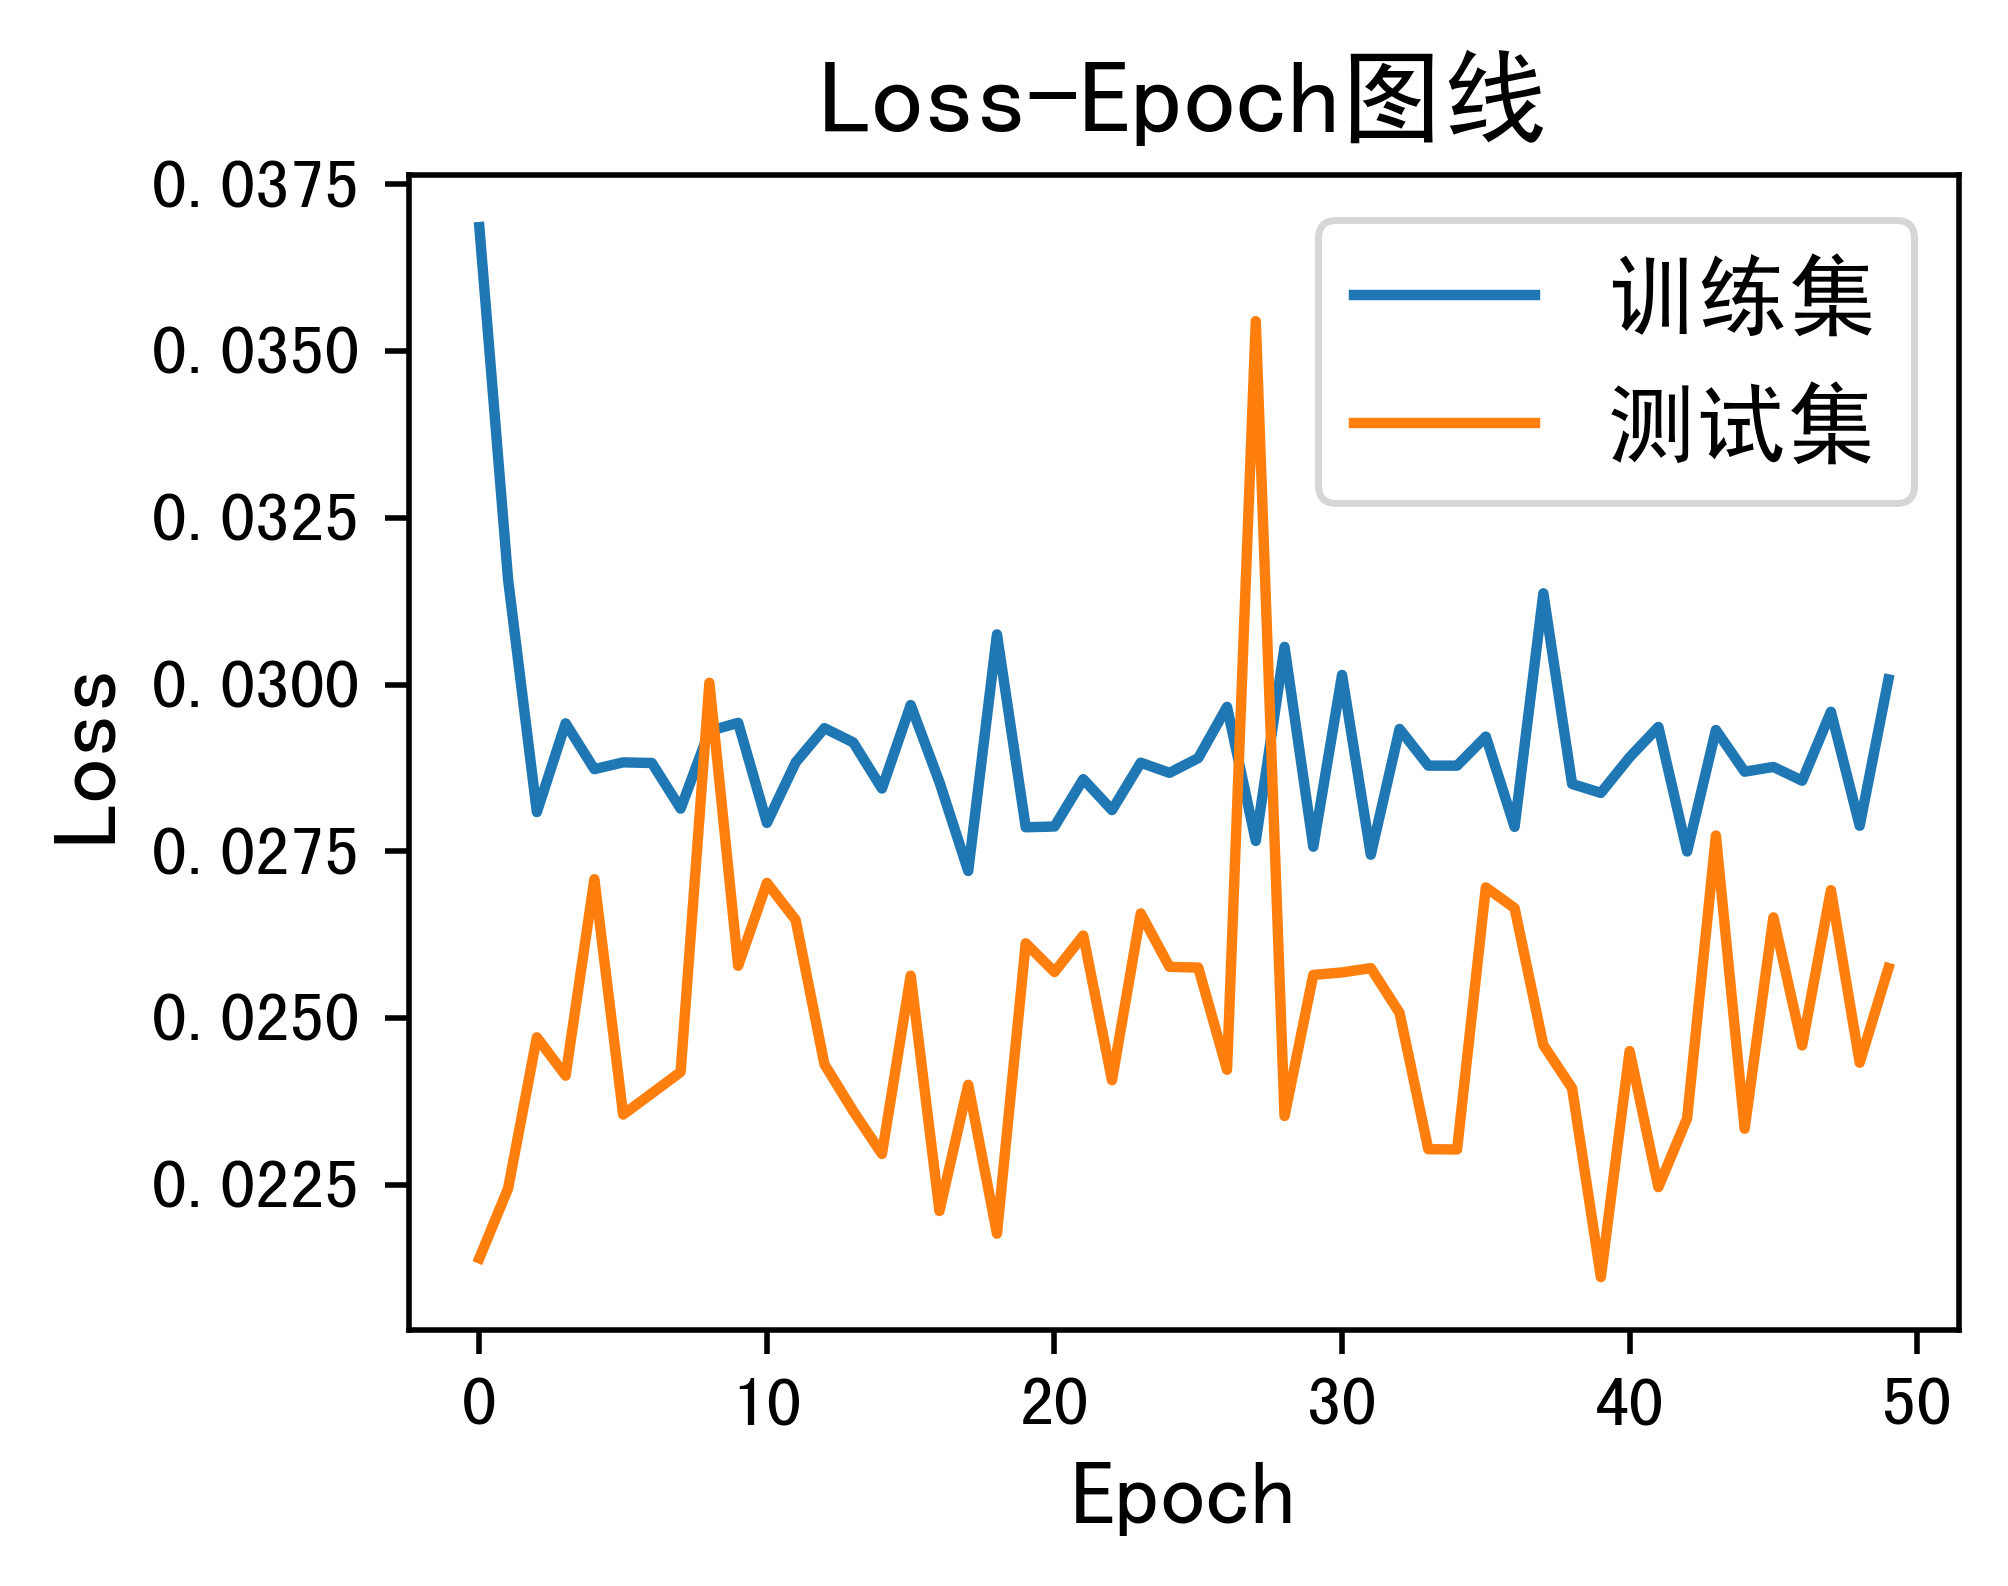

In [11]:
LossEpochPlot(
    LOSS_HISTORY=(LOSS_HISTORY_TRAIN, LOSS_HISTORY_TEST),
    LEGEND=["训练集", "测试集"],
    TITLE="Loss-Epoch图线",
    FILE_NAME="Images/07LinearRegression_Loss_Epoch.jpg",
    LOG_YAXIS=False,
    SAVE_FIG=True,
)

得到传递矩阵


In [12]:
TranferMatrix_LinearRegression = MyLinearRegression.linear.weight.detach().cpu()

检查模型稳定性


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

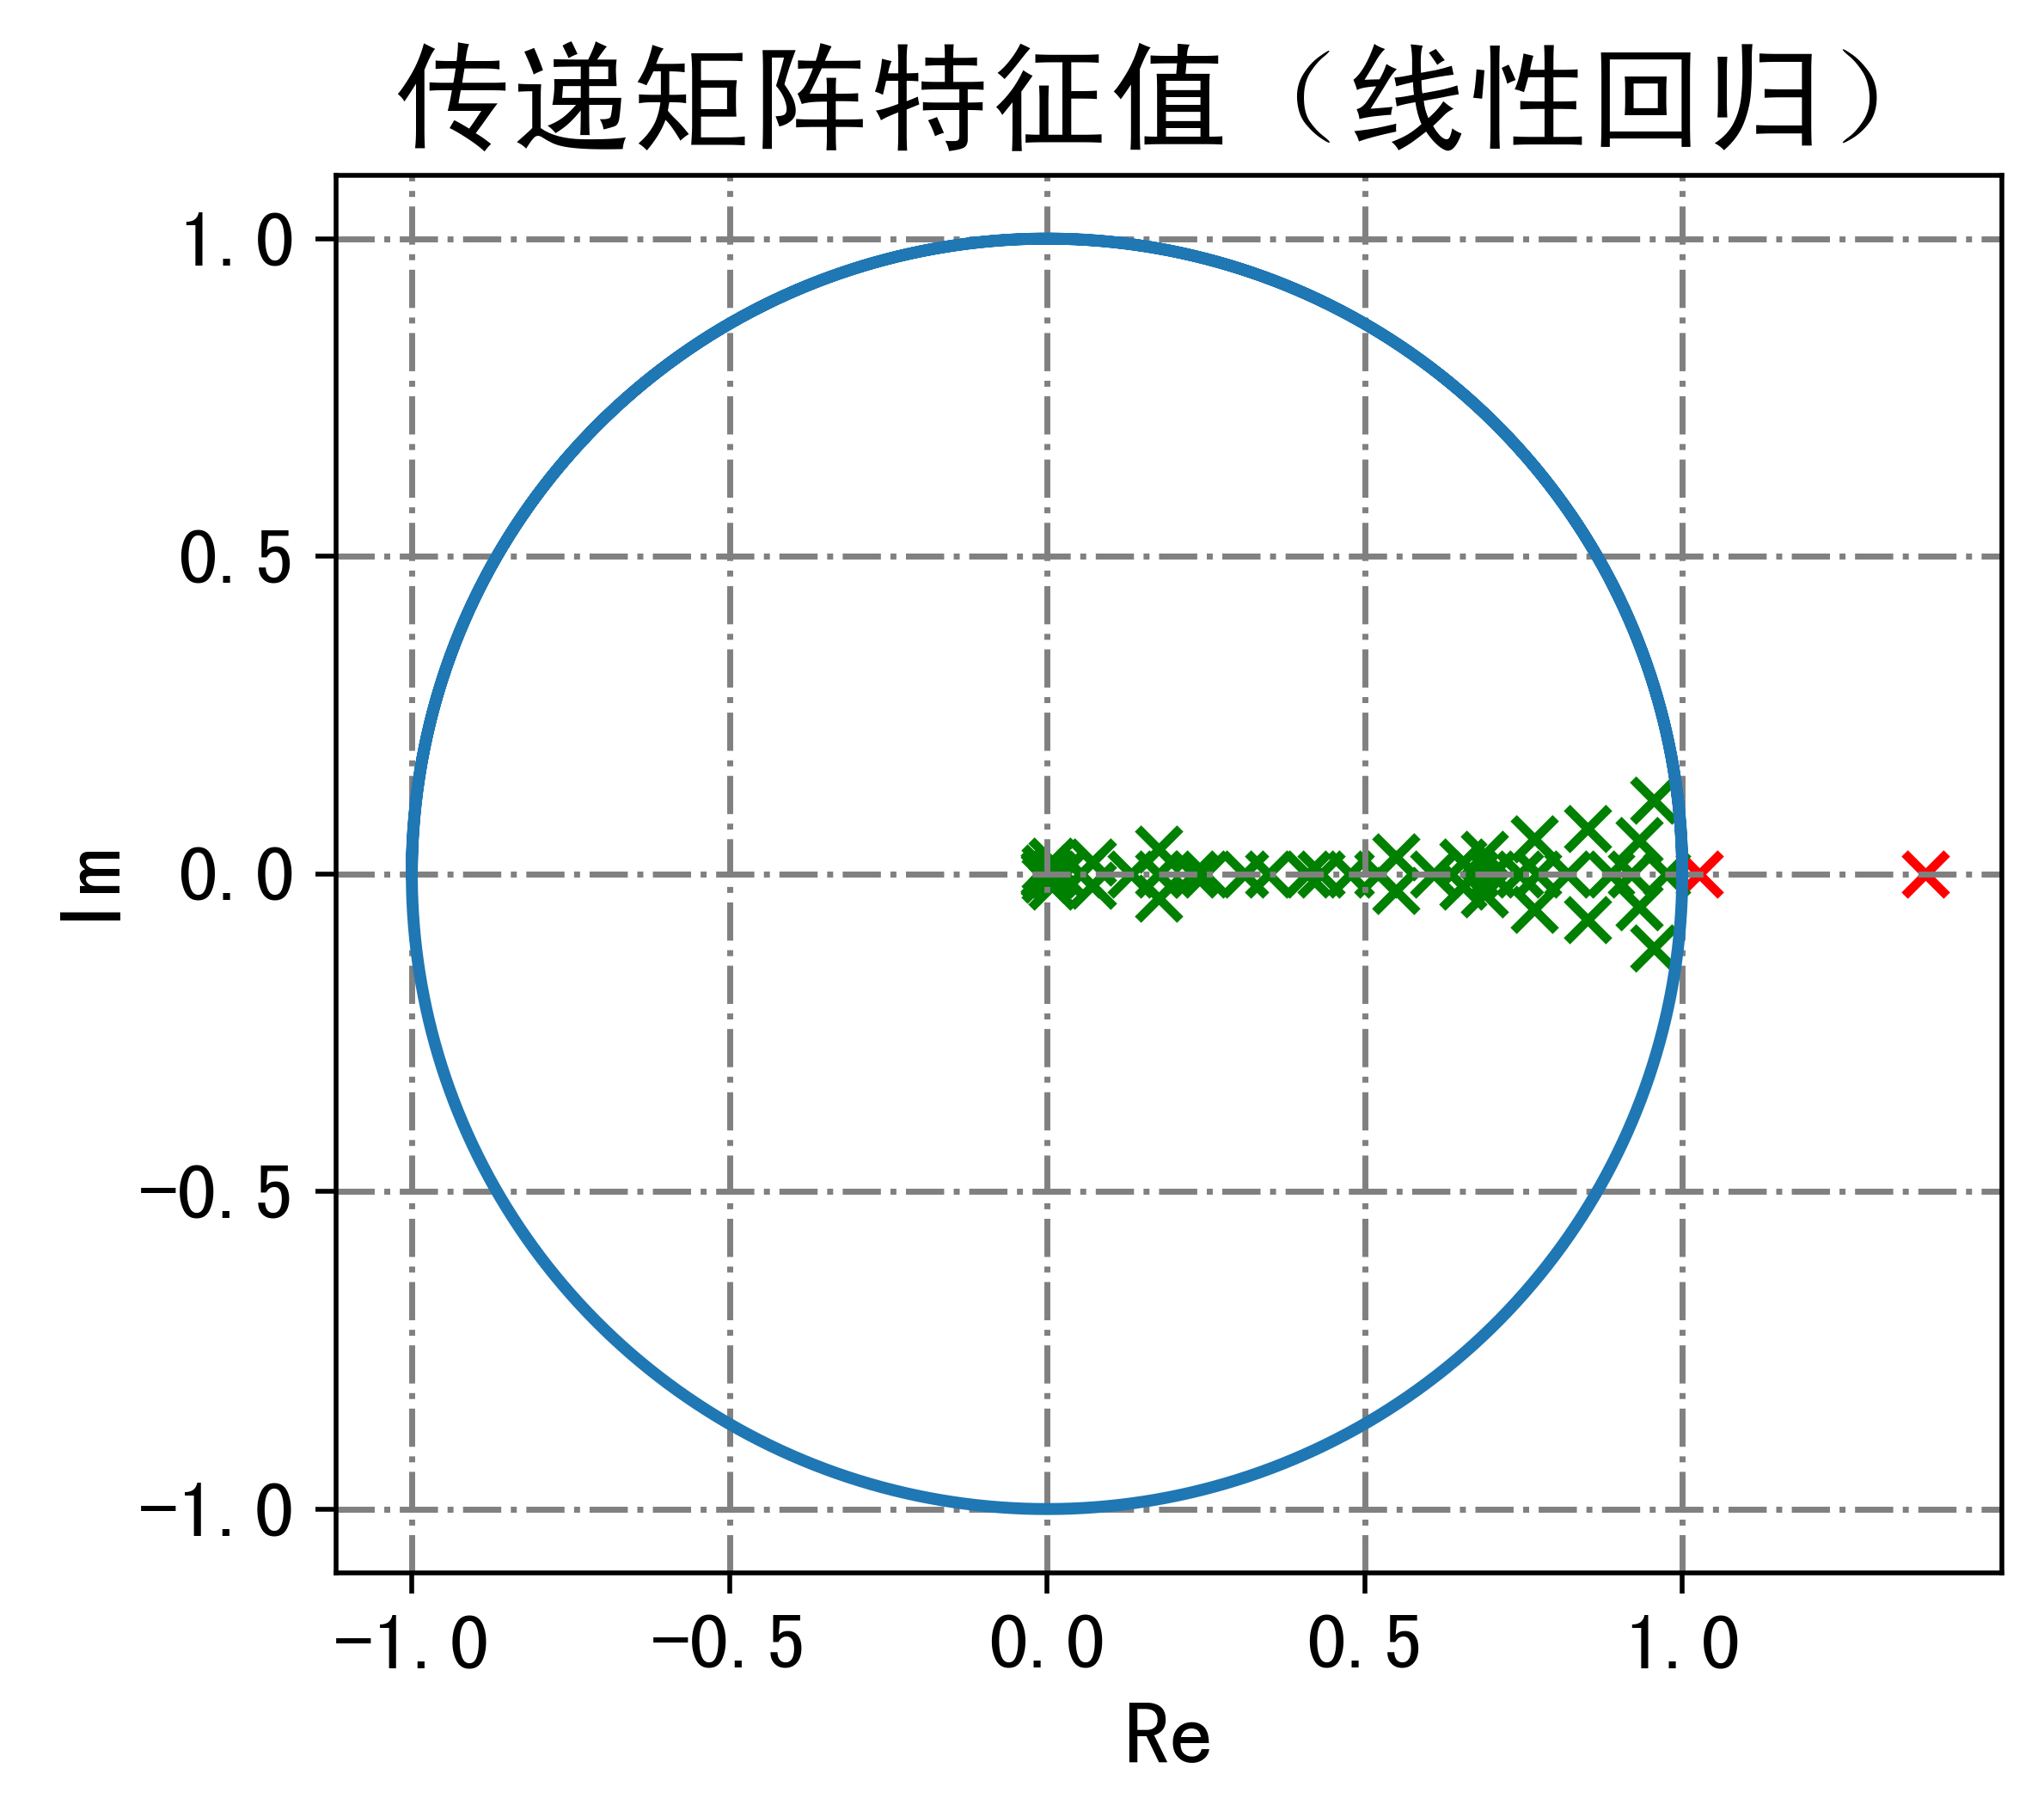

In [13]:
PlotEigenValues(
    TranferMatrix_LinearRegression.numpy(),
    FONTSIZES=[13, 15, 20],
    FIG_SIZE=(5, 5),
    TITLE="传递矩阵特征值（线性回归）",
    FILE_NAME="Images/07Eigenvalues_LinearRegression.jpg",
    SAVE_FIG=True,
)

SVD求伪逆，得到传递矩阵


/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:295: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/Visualization.py:297: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/ctc/桌面/Git Projects/Optimization_Group_Work/

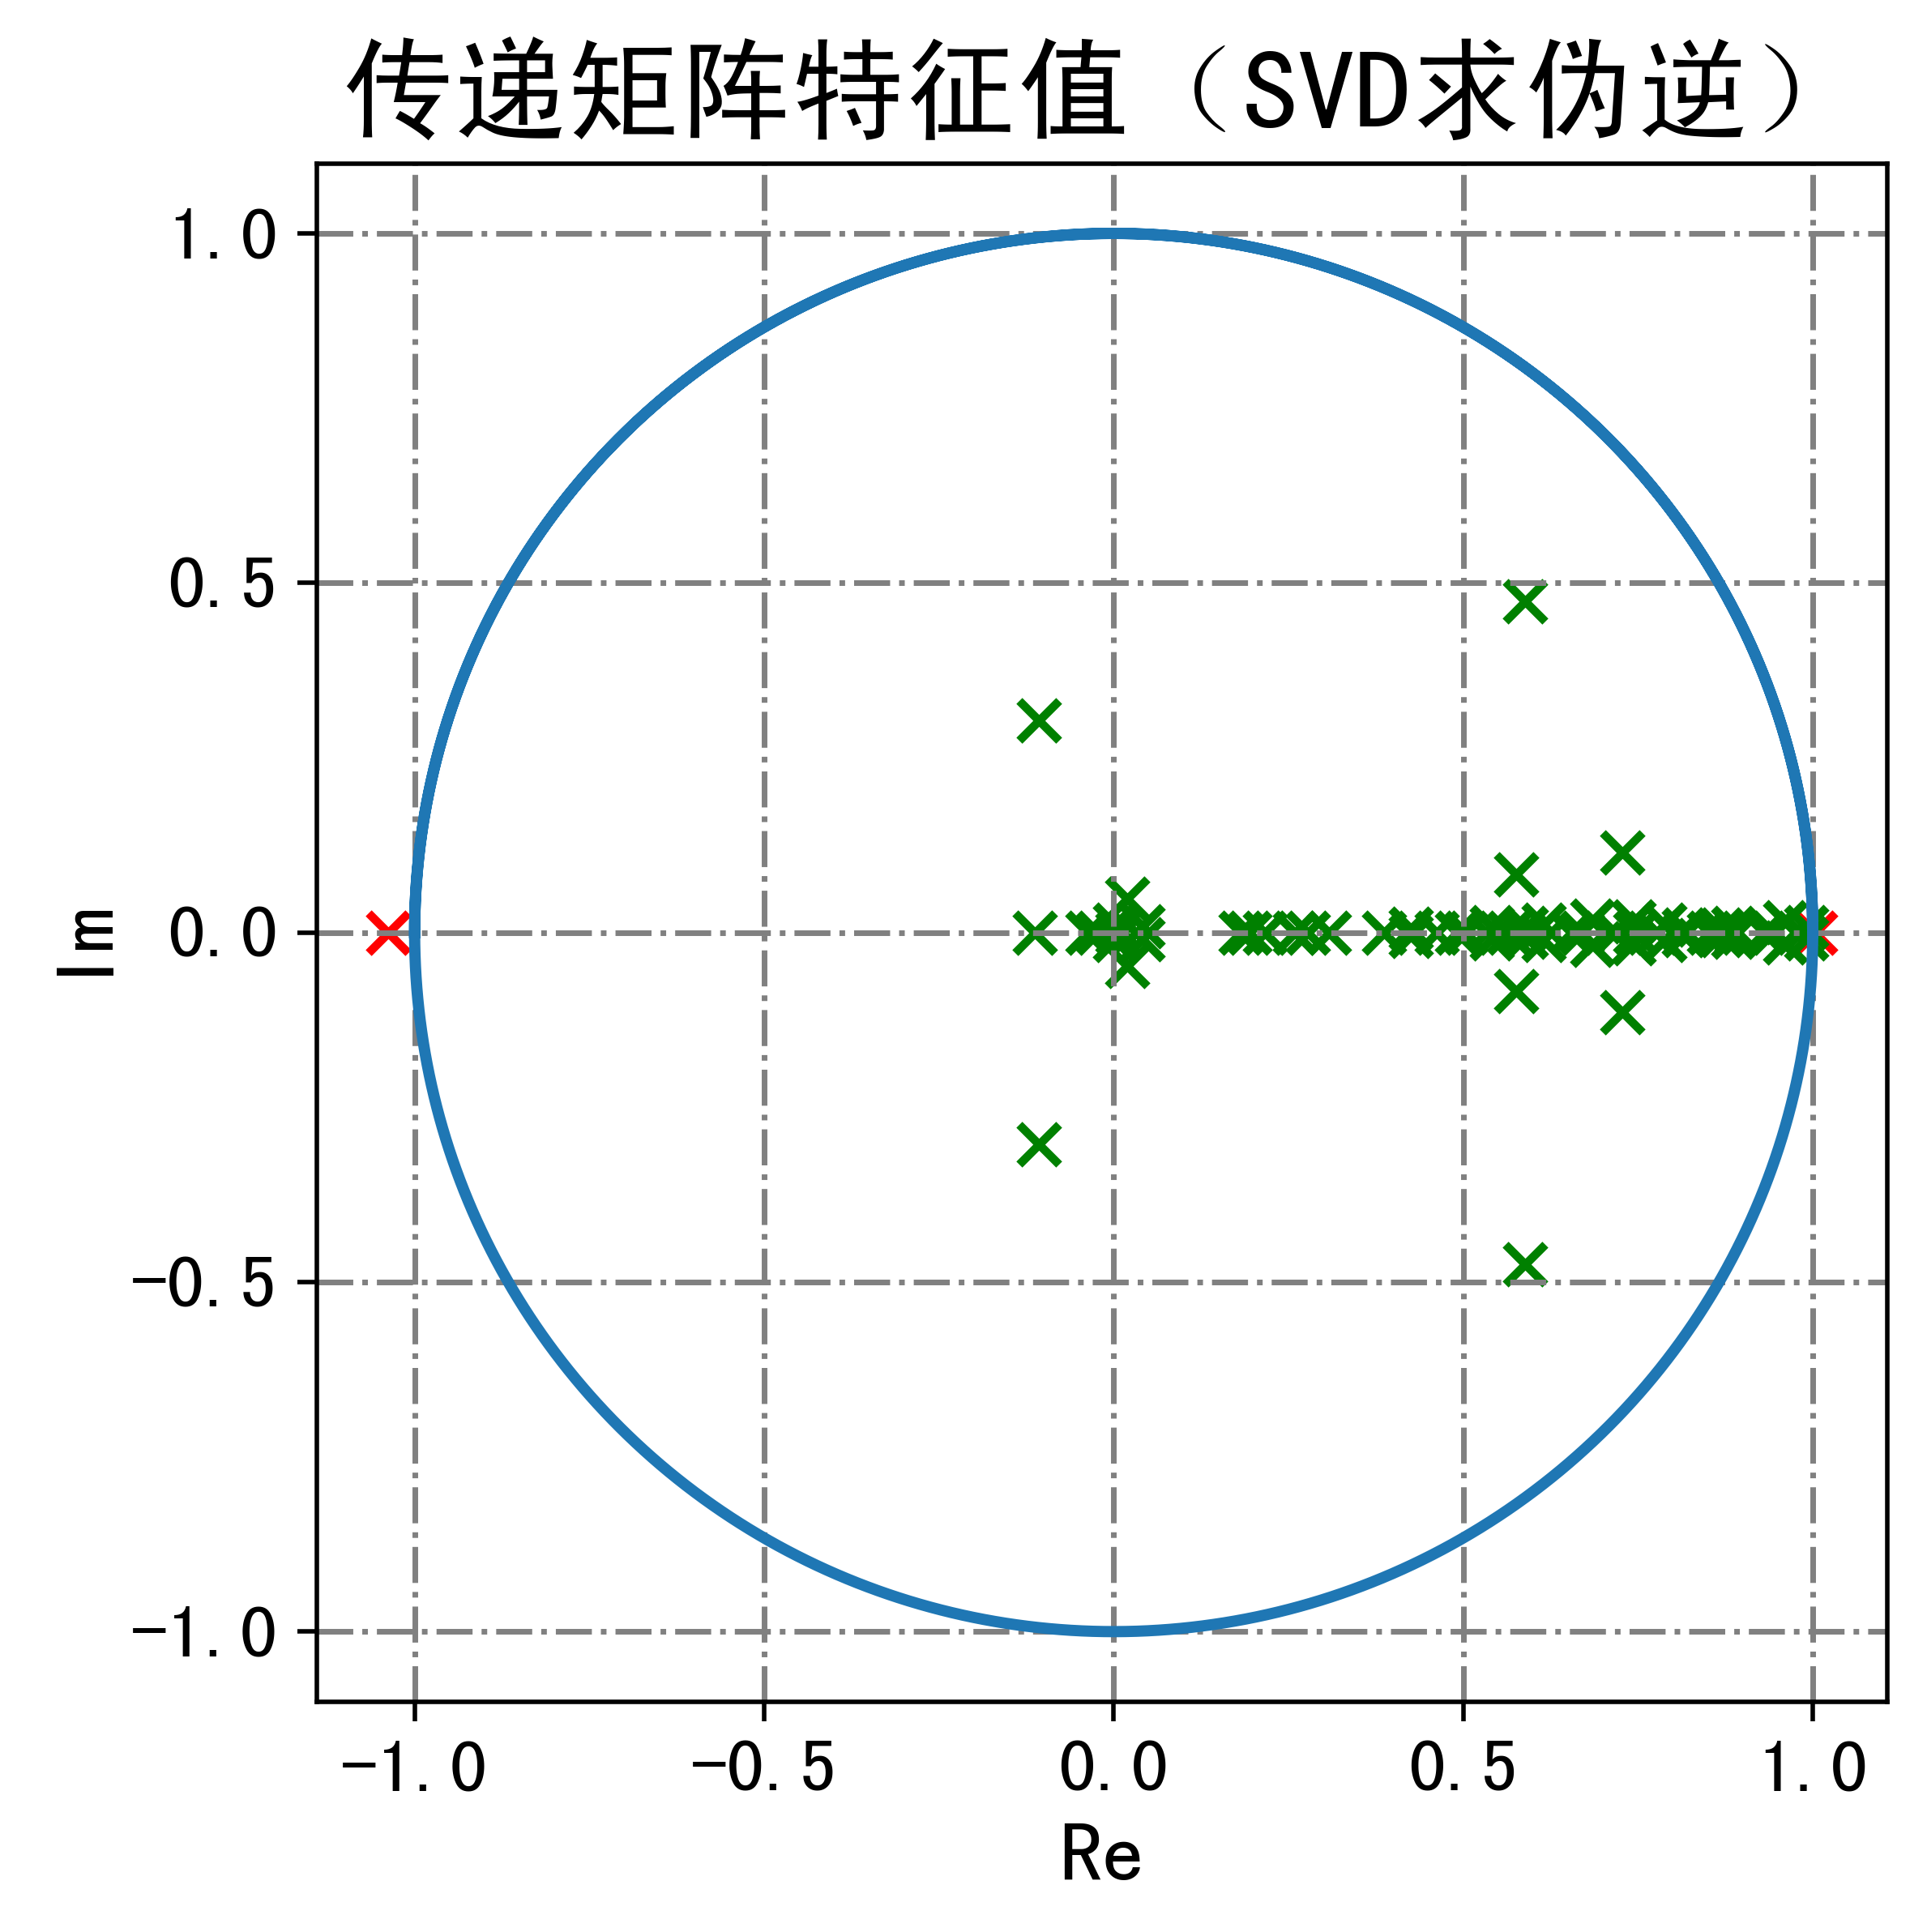

In [14]:
import numpy as np


def DMD(X, Xprime, RANK=None):
    if RANK is None:
        RANK = X.shape[0]
    # Step 1 Apply SVD on former state data X
    U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
    # Truncate U,Sigma,V to order r
    Ur = U[:, :RANK]
    Sigmar = np.diag(Sigma[:RANK])
    VTr = VT[:RANK, :]

    # Step 2 Obtain \tilde{A}
    Atilde = np.linalg.solve(Sigmar.T, (Ur.conj().T @ Xprime @ VTr.T).T).T

    # Step 3 Obtain \tilde{A} 's eigensystem
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)

    # Step 4 Reconstruct DMD mode \Phi
    # print(Xprime.dtype,Sigma.dtype,VTr.dtype,W.dtype)
    Phi = Xprime @ np.linalg.solve(Sigmar.T, VTr).T @ W
    alpha1 = Sigmar @ VTr[:, 0]
    b = np.linalg.solve(W @ Lambda, alpha1)
    return Phi, Lambda, b


_, TranferMatrix_SVDpinv, _ = DMD(
    feature_tensor.numpy()[:-1, :].T, feature_tensor.numpy()[1:, :].T, RANK=None
)
PlotEigenValues(
    MATRIX=TranferMatrix_SVDpinv,
    FONTSIZES=[13, 15, 20],
    FIG_SIZE=(5, 5),
    TITLE="传递矩阵特征值（SVD求伪逆）",
    FILE_NAME="Images/07Eigenvalues_SVD.jpg",
    SAVE_FIG=True,
)

## 5. 2019年数据预处理


In [15]:
import os

# 设置文件夹路径
folder_path = "Data/Weather 2019/"
# 获取文件夹中所有csv文件的路径
file_paths = [
    os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")
]
# 选取需要的列
COLUMN_INDEX = [
    "Index",
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Visibility (km)",
    "Stn Press (kPa)",
]
# 读取所有csv文件并合并为一个DataFrame
df = pd.concat([pd.read_csv(f) for f in file_paths])
# 最左侧加入表头为Index的序号
df.insert(0, "Index", range(len(df)))
data = df[COLUMN_INDEX]
# 插值补全数据
data = data.interpolate(method="linear")
# 保存为.csv格式
data.to_csv("Data/2019data.csv", index=False)

## 6. 模型预测效果


In [16]:
# 选取需要的列
COLUMN_INDEX = [
    "Temp (°C)",
    "Dew Point Temp (°C)",
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    "Stn Press (kPa)",
]

data_2019 = pd.read_csv("Data/2019data.csv")[COLUMN_INDEX].to_numpy()
data_formmer = pd.read_csv("Data/DataSet.csv")[COLUMN_INDEX].to_numpy()
data_2019_tensor = torch.tensor(data_2019, dtype=torch.float32)
data_formmer_tensor = torch.tensor(data_formmer, dtype=torch.float32)

构造张量,便于之后的多步预测


In [22]:
FORCAST_TIMESTEPS = 6

data_forcast_formmer_tensor = torch.concat(
    (
        data_formmer_tensor[-FORCAST_TIMESTEPS:, :],
        data_2019_tensor[:-FORCAST_TIMESTEPS, :],
    ),
    dim=0,
)

预测结果


In [23]:
ENCODER.eval()
DECODER.eval()
TranferMatrix_SVDpinv = torch.tensor(TranferMatrix_SVDpinv.real)

CHOOSE_SVDpinv = True
if CHOOSE_SVDpinv:
    TranferMatrix = TranferMatrix_SVDpinv
else:
    TranferMatrix = TranferMatrix_LinearRegression
with torch.no_grad():
    data_forcast_tensor = DECODER(
        (
            torch.matrix_power(TranferMatrix, FORCAST_TIMESTEPS).real.to(torch.float32)
            @ ENCODER(data_forcast_formmer_tensor).T
        ).T
    )

/tmp/ipykernel_1009086/3231915492.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TranferMatrix_SVDpinv = torch.tensor(TranferMatrix_SVDpinv.real)


计算RMSE


In [24]:
RMSE = torch.sqrt(
    torch.sum(torch.pow(data_forcast_tensor - data_2019_tensor, 2), dim=0)
    / data_2019_tensor.shape[0]
)
RMSE

tensor([ 8.0142,  8.4008, 13.9416, 10.4881,  0.7913])

查看预测效果


/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ctc/anaconda3/envs/D2L/lib/python3.11/site-packages/IPython/core/pylabtools.p

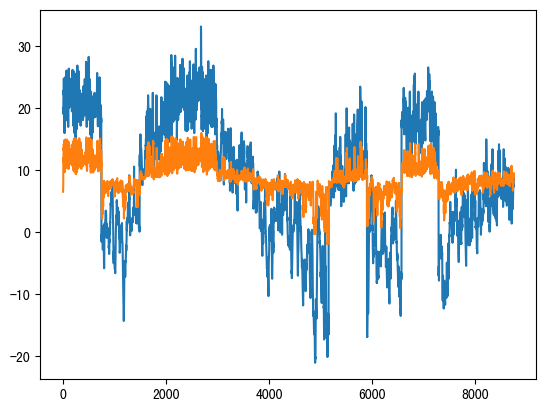

In [25]:
import matplotlib.pyplot as plt

plt.plot(torch.arange(0, data_2019_tensor.shape[0]), data_2019_tensor[:, 0])
plt.plot(torch.arange(0, data_forcast_tensor.shape[0]), data_forcast_tensor[:, 0])
plt.show()